In [ ]:
from google.colab import drive
drive.mount('/content/New')

Mounted at /content/New


In [ ]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, TimeDistributed
import keras



from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

In [ ]:
files = glob.glob("/content/New/MyDrive/parkinsons/*_??.txt")
shuffle(files)

In [ ]:
files[0]

'/content/New/MyDrive/parkinsons/JuPt28_02.txt'

In [ ]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1

In [ ]:
fdf = pd.DataFrame(files)

# Do note that I am using a binary classification only below, use use getClassification for all classes
fdf['classification']  = fdf[0].map(lambda x: getClassForHealthyOrNot(x))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1917)
for train_index, test_index in split.split(fdf, fdf['classification']):
    strat_train = fdf.loc[train_index]
    strat_test  = fdf.loc[test_index]
    
train_files = strat_train[0].values
test_files = strat_test[0].values

In [ ]:
len(train_files), len(test_files)

(244, 62)

In [ ]:
fdf

,0,classification
0,/content/New/MyDrive/parkinsons/JuPt28_02.txt,1
1,/content/New/MyDrive/parkinsons/GaPt03_01.txt,1
2,/content/New/MyDrive/parkinsons/SiPt12_01.txt,1
3,/content/New/MyDrive/parkinsons/SiCo29_01.txt,0
4,/content/New/MyDrive/parkinsons/JuCo25_01.txt,0
...,...,...
301,/content/New/MyDrive/parkinsons/JuPt22_01.txt,1
302,/content/New/MyDrive/parkinsons/GaCo02_02.txt,0
303,/content/New/MyDrive/parkinsons/JuPt01_06.txt,1
304,/content/New/MyDrive/parkinsons/JuPt26_07.txt,1


In [ ]:
def parkinsonOneHot(label, len):
    onehot = np.zeros([len, 2])

    if (label == 0):
        onehot[:, 0] = 1
    else:
        onehot[:, 1] = 1
    return onehot

In [ ]:

sc = StandardScaler()

def initScalerWith():
    d = pd.DataFrame()
    
    for f in train_files:
        data = pd.read_csv(f, sep='\t')
        data['classification'] = getClassForHealthyOrNot(f)
        d = pd.concat([data], axis=1)
    return d.values

sc.fit(initScalerWith())

StandardScaler()

In [ ]:
def readSensorDataFromFile(f):
    data = pd.read_csv(f, sep='\t')
    data['classification'] = getClassForHealthyOrNot(f)
    return sc.transform(data.values)

In [ ]:
def produceImagesFromFile(file, image_height, offset=100):
    r = pd.DataFrame()
   
    # Width is 16 pixels
    d = readSensorDataFromFile(file)[:, 1:17]

    for i in range(0, d.shape[0], offset):
        if (i+image_height > d.shape[0]):
            continue
        r = pd.concat([r, pd.DataFrame(d[i:i+image_height])], axis=0)

    return r.values.reshape(-1, 16, image_height, 1), getClassForHealthyOrNot(file)

In [ ]:
batch_size = 16
image_height = 192

def generate_arrays_from_file(files):
    while 1:
         for f in files:
            #print("processing ", f)
            x_batch, y_class = produceImagesFromFile(f, image_height=image_height)
            y_batch = parkinsonOneHot(y_class, x_batch.shape[0])
       
            # Batch size defined as "batch_size" in the initialization
            for i in range (0, len(x_batch), batch_size):
                yield (x_batch[i:i+batch_size], y_batch[i:i+batch_size])

In [ ]:
def count_steps_in_epoch(files, batch_size = 64, image_height = 192):
    count = 0
    for f in files:
        xb, _ = produceImagesFromFile(f, image_height=image_height)
        count = count + int(xb.shape[0] / batch_size)
    return count

In [ ]:
batch_size = 16
image_height = 240

training_set_steps_per_epoch = count_steps_in_epoch(train_files, batch_size=batch_size, image_height=image_height)
test_set_steps_per_epoch = count_steps_in_epoch(test_files, batch_size=batch_size, image_height=image_height)

a,b = next(generate_arrays_from_file(test_files))

print("Training: ", training_set_steps_per_epoch, " samples, testing: ", test_set_steps_per_epoch)

Training:  1494  samples, testing:  402


In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='glorot_uniform',
                 input_shape=a.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform',
                 input_shape=a.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)


checkpoint = ModelCheckpoint("/content/New/MyDrive/Model/Model_Tune/model_parkinsons_v10.h5", 
                             monitor='val_accuracy', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
history = model.fit(generate_arrays_from_file(train_files), 
                    validation_data=generate_arrays_from_file(test_files),
                    steps_per_epoch=training_set_steps_per_epoch, 
                    validation_steps=test_set_steps_per_epoch,
                    verbose=2,
                    epochs=50, 
                    shuffle=True,
                    use_multiprocessing=True,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/50
1494/1494 - 32s - loss: 0.7522 - accuracy: 0.6796 - val_loss: 0.6024 - val_accuracy: 0.7443 - 32s/epoch - 22ms/step
Epoch 2/50
1494/1494 - 34s - loss: 0.7463 - accuracy: 0.6937 - val_loss: 0.5867 - val_accuracy: 0.7443 - 34s/epoch - 22ms/step
Epoch 3/50
1494/1494 - 28s - loss: 0.8029 - accuracy: 0.6944 - val_loss: 0.6580 - val_accuracy: 0.7134 - 28s/epoch - 19ms/step
Epoch 4/50
1494/1494 - 33s - loss: 0.8936 - accuracy: 0.6977 - val_loss: 0.5820 - val_accuracy: 0.7443 - 33s/epoch - 22ms/step
Epoch 5/50
1494/1494 - 29s - loss: 0.7725 - accuracy: 0.6792 - val_loss: 0.5808 - val_accuracy: 0.7443 - 29s/epoch - 19ms/step
Epoch 6/50
1494/1494 - 29s - loss: 0.6041 - accuracy: 0.7125 - val_loss: 0.5755 - val_accuracy: 0.7443 - 29s/epoch - 19ms/step
Epoch 7/50
1494/1494 - 26s - loss: 0.8180 - accuracy: 0.6960 - val_loss: 0.5700 - val_accuracy: 0.7442 - 26s/epoch - 17ms/step
Epoch 8/50
1494/1494 - 29s - loss: 0.8646 - accuracy: 0.6984 - val_loss: 0.5767 - val_accuracy: 0.7443 - 29s/ep

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 240, 32)       832       
                                                                 
 activation (Activation)     (None, 16, 240, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 120, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 120, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 8, 120, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 60, 64)        0         
 2D)                                                    

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


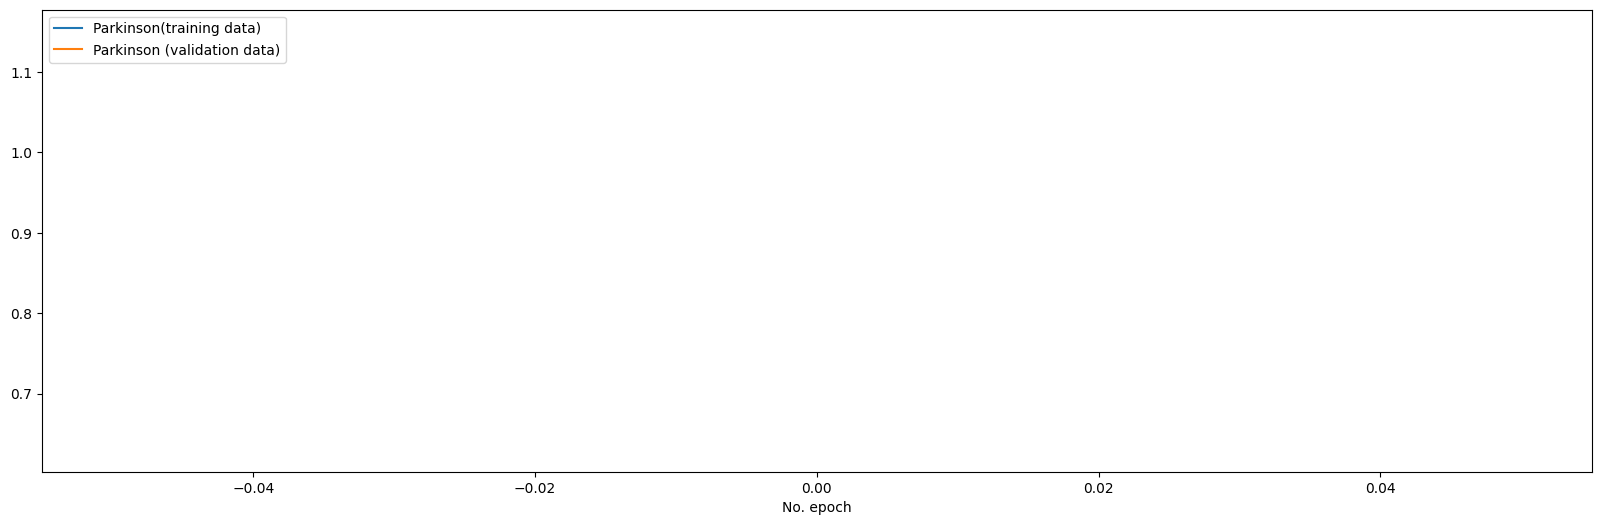

In [ ]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

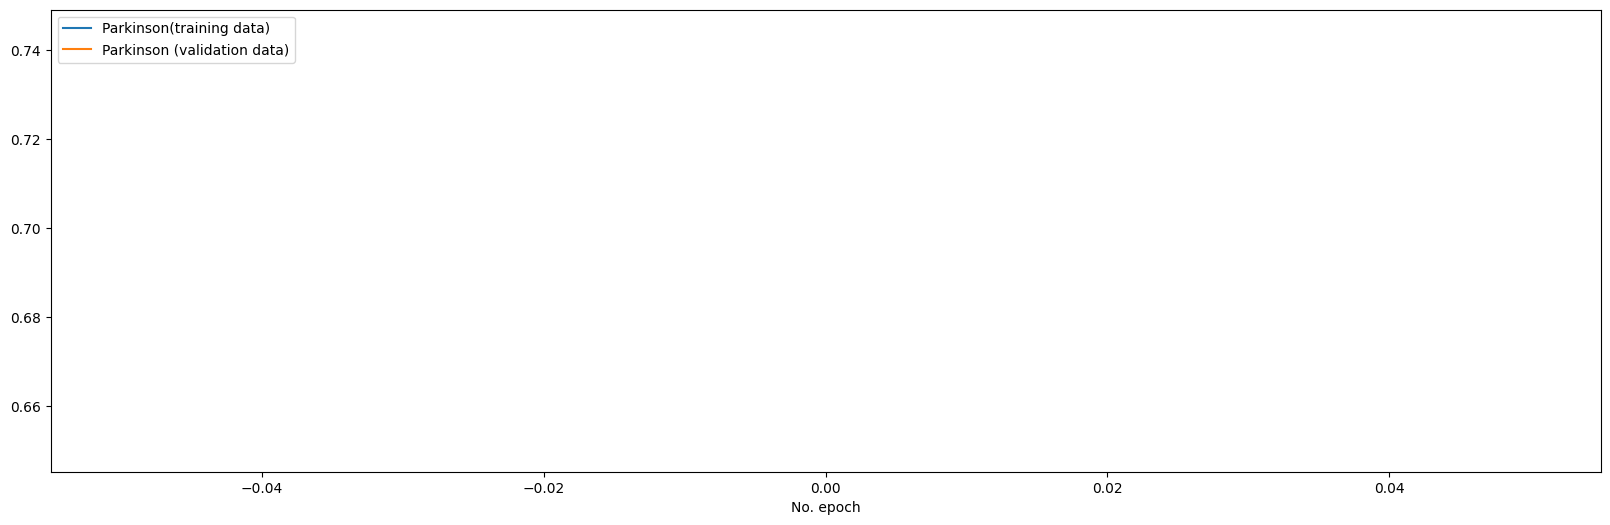

In [ ]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
max(history.history['val_accuracy'])

0.7443181872367859

In [ ]:
history.history['val_accuracy']

[0.7443181872367859]

In [ ]:
max(history.history['accuracy'])

0.650031566619873

In [ ]:
history.history['loss']

[1.151228904724121]

In [ ]:
min(history.history['loss'])

1.151228904724121

In [ ]:
min(history.history['val_loss'])

0.6290410161018372

In [ ]:
parkmodel = load_model("/content/New/MyDrive/Model/Model_Tune/model_parkinsons_v6.h5")


In [ ]:
n_park = 0
n_control = 0

for f in test_files:
    if (f.find("Co") > 0):
        n_control += 1
    else:
        n_park += 1

In [ ]:
n_control, n_park

In [ ]:
LOAD_MODEL = False
correct = 0
incorrect = 0

true_y = []
predicted_y = []

if (LOAD_MODEL):
    parkmodel = load_model("/content/New/MyDrive/Model/Model_Tune/model_parkinsons_v7.h5")

for f in test_files:
    d_x, label = produceImagesFromFile(file=f, image_height=240)
    
    predictions = parkmodel.predict_classes(d_x)
    
    predict_distribution = pd.Series(predictions).value_counts()
    predictClass = predict_distribution.idxmax()
    
    true_y.append(label)
    predicted_y.append(predictClass)
    
    if (label == predictClass):
        prediction_text = "correct"
        correct += 1
    else:
        prediction_text = "incorrect (vote distribution: %s)" % (predict_distribution.values)
        incorrect += 1

    output = ("prediction was %s for %s") % (prediction_text, os.path.basename(f))
    print(output)

print(("Number of samples: %d, %d correct, %d incorrect.") % 
    (correct+incorrect, correct, incorrect))

In [ ]:
from sklearn.metrics import recall_score, f1_score, precision_score
recall = recall_score(true_y, predicted_y)
precision = precision_score(true_y, predicted_y)
f1 = f1_score(true_y, predicted_y)

print('Recall score: {0:0.2f}'.format(recall))
print('Precision score: {0:0.2f}'.format(precision))
print('F1-score: {0:0.2f}'.format(precision))